# Corn Disease Classification using EfficientNetB0

This notebook implements corn disease classification using the EfficientNetB0 architecture with transfer learning.

In [1]:
# Install required packages
%pip install tensorflow==2.17.0 kagglehub matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import kagglehub
import numpy as np
import matplotlib.pyplot as plt

c:\Users\Terrell\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = kagglehub.dataset_download("smaranjitghose/corn-or-maize-leaf-disease-dataset")
data = r'C:\Users\Terrell\.cache\kagglehub\datasets\smaranjitghose\corn-or-maize-leaf-disease-dataset\versions\1\data'

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data, image_size=(224, 224), batch_size=32,
    validation_split=0.2, subset="training", seed=42
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data, image_size=(224, 224), batch_size=32,
    validation_split=0.2, subset="validation", seed=42
)

class_names = train_ds_raw.class_names
from tensorflow.keras.applications.efficientnet import preprocess_input

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.1)
])

def preprocess(ds, augment=False):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    return ds.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(tf.data.AUTOTUNE)

train_ds = preprocess(train_ds_raw, augment=True).shuffle(1000)
val_ds = preprocess(val_ds_raw)

Found 4188 files belonging to 4 classes.
Using 3351 files for training.
Found 4188 files belonging to 4 classes.
Using 837 files for validation.


In [4]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
model = Model(inputs=base_model.input, outputs=Dense(len(class_names), activation='softmax')(x))

for layer in base_model.layers:
    layer.trainable = False

In [5]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.7938 - loss: 0.6269 - val_accuracy: 0.8841 - val_loss: 0.3731 - learning_rate: 1.0000e-04
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9084 - loss: 0.2877 - val_accuracy: 0.9104 - val_loss: 0.2676 - learning_rate: 1.0000e-04
Epoch 3/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.9275 - loss: 0.2169 - val_accuracy: 0.9211 - val_loss: 0.2355 - learning_rate: 1.0000e-04
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9355 - loss: 0.1851 - val_accuracy: 0.9259 - val_loss: 0.2156 - learning_rate: 1.0000e-04
Epoch 5/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9424 - loss: 0.1663 - val_accuracy: 0.9331 - val_loss: 0.1982 - learning_rate: 1.0000e-04


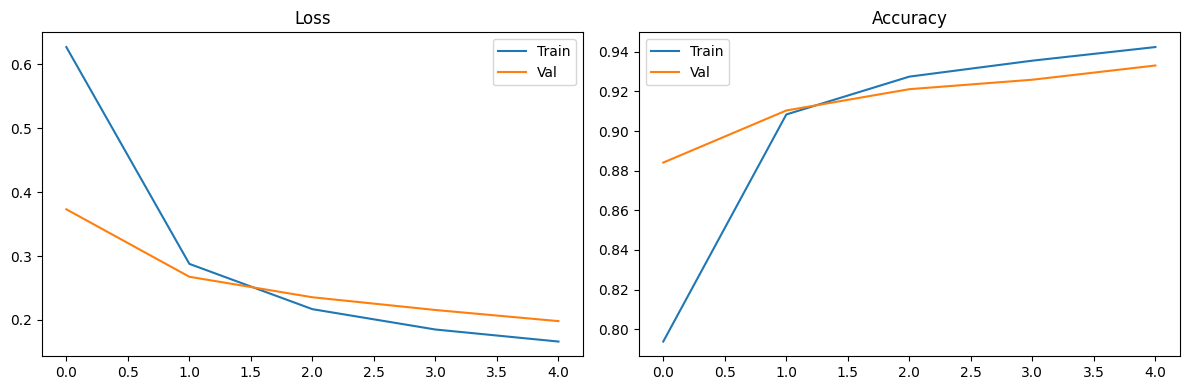

In [6]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(val_ds), axis=1)
y_true = np.concatenate([y for _, y in val_ds], axis=0)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 897ms/step
Classification Report:
                precision    recall  f1-score   support

        Blight       0.85      0.94      0.89       225
   Common_Rust       0.98      0.97      0.98       244
Gray_Leaf_Spot       0.88      0.73      0.80       126
       Healthy       0.99      0.99      0.99       242

      accuracy                           0.93       837
     macro avg       0.93      0.91      0.92       837
  weighted avg       0.93      0.93      0.93       837


Confusion Matrix:
[[212   2   9   2]
 [  5 237   2   0]
 [ 31   3  92   0]
 [  1   0   1 240]]


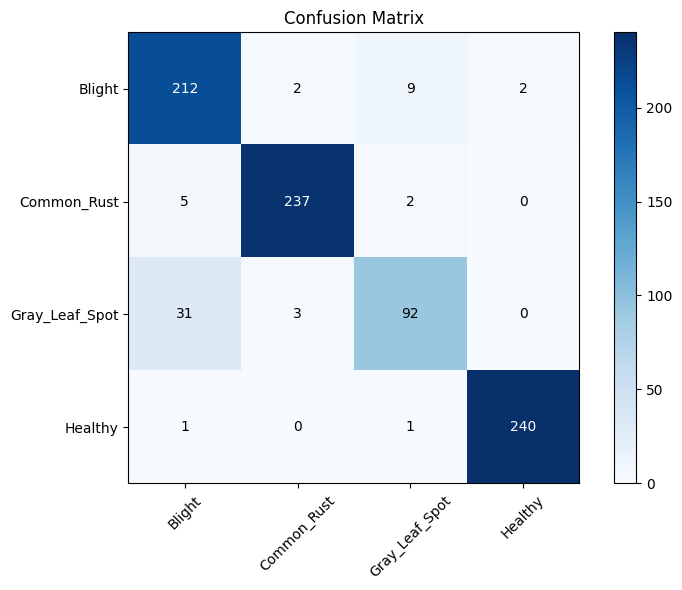

In [8]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black")

plt.tight_layout()
plt.show()